# Generating plots for different algorithms

In [12]:
from stable_baselines3 import PPO, DQN, A2C, SAC
import numpy as np
import pandas as pd
from meal_planning_environment import MaxNutritionEnv, HeuristicEnv, GPTOnlyEnv, RLHFEnv
from meal_planning_environment import run_with_learning_algorithm
from dietkit import load_ingredient, load_menu, load_diet

import os 
import time
import sqlite3

## Initialize dietkit

In [13]:
all_ingredients = load_ingredient(sample_language = 'eng')
meal_dict = load_menu(ingredients = all_ingredients, sample_language = 'eng')
example_mealplans = load_diet(menus = meal_dict, num_loads = 100, sample_language = 'eng', sample_name = 'ML')

possible_meals = np.array(list(meal_dict.keys()))
meal_categories = np.array([meal.category if isinstance(meal.category, str) else meal.category[0] for meal in meal_dict.values()])
nutrition_data = pd.DataFrame([meal.nutrition for meal in meal_dict.values()], index=possible_meals)

display(possible_meals)
display(nutrition_data)

array(['S watermelon punch (without milks)', 'Dried persimmon',
       'S kyogo grape (100g)', ..., 'Green onion kimchi',
       'Pickled paprika', 'empty'], dtype='<U72')

,Energy,Protein,Fat,Carbohydrate,Total Dietary,Calcium,Iron,Sodium,Vitamin A,Vitamin B1 (Thiamine),Vitamin B2 (Rivoflavin),Vitamin C,Linoleic Acid,Alpha-Linolenic Acid
S watermelon punch (without milks),55.00,0.7900,0.05000,13.8180,0.200,7.200,0.18600,0.600,71.083333,0.024000,0.03000,0.0000,14.2500,2.9300
Dried persimmon,76.50,0.5820,0.04800,20.5830,3.360,6.300,0.19200,0.900,13.725000,0.003000,0.06720,1.5330,0.0000,8.6010
S kyogo grape (100g),61.00,0.4300,0.04000,16.3800,0.400,4.000,0.17000,1.000,2.166667,0.026000,0.04700,0.1300,11.8900,6.0900
S dried persimmon,85.60,0.7720,0.03200,22.9800,3.400,5.600,0.24800,0.400,9.533333,0.003600,0.09720,1.0680,0.0000,5.0440
S fruit punch,101.05,3.6700,3.36450,14.8900,0.790,117.650,0.19850,36.000,91.166667,0.040350,0.19110,1.8925,86.6605,10.6925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ponytail radish kimchi,10.25,0.5050,0.05000,1.9725,0.775,10.500,0.16750,173.000,5.541667,0.003250,0.01900,0.4125,19.7050,9.4775
Kohlrabi watery kimchi,5.50,0.2900,0.01250,1.2900,0.600,10.500,0.06750,1.750,0.250000,0.203750,0.00875,0.0000,1.9650,5.1100
Green onion kimchi,12.25,0.6250,0.14500,2.1275,1.150,15.000,0.18250,163.750,26.854167,0.012750,0.02850,0.5550,79.8050,17.1425
Pickled paprika,7.94,0.2017,0.03005,1.9859,0.348,1.675,0.08145,67.204,4.850000,0.003675,0.02709,24.2820,12.4483,6.5448


# Load carbon impact data

In [14]:
sql_conn = sqlite3.connect('carbon_impacts.db')
carbon_impacts_df = pd.read_sql_query("SELECT * FROM carbon_impacts", sql_conn)
carbon_impacts_df['meal'] = carbon_impacts_df['meal'].str.replace('Menu object: ', '')
display(carbon_impacts_df)
carbon_data = dict(zip(carbon_impacts_df.meal, carbon_impacts_df.impact))

,meal,impact,explanation
0,Dried persimmon,8.000000,The carbon impact score is 9. Drying persimmon...
1,S watermelon punch (without milks),-0.333333,The carbon impact score is -5. \n\nCarbonated ...
2,S kyogo grape (100g),4.000000,The carbon impact score is 6. Grapes have a re...
3,S dried persimmon,7.000000,The carbon impact score is 7. Dried persimmon ...
4,S fruit punch,-2.666667,The carbon impact score is -5. \n\nThis meal c...
...,...,...,...
3230,Ponytail radish kimchi,4.000000,The carbon impact score is 3. \n\nKimchi is ty...
3231,Kohlrabi watery kimchi,5.333333,The carbon impact score is 5. Kohlrabi is a lo...
3232,Green onion kimchi,3.333333,The carbon impact score is 2. \n\nKimchi and P...
3233,Pickled paprika,5.000000,The carbon impact score is 8. This meal has a ...


## Initialize MealPlanningEnv
Initialize each of the following environments:
1. MaxNutritionEnv
1. MaxNutritionCompositionEnv
2. HeuristicEnv
3. GPTOnlyEnv
4. RLHFEnv

Descriptions to write
-   Explaining the custom gym environment
    -   States, actions, observations, reward, agent
-   Explaining the custom random agent
-   Explaining the dataset
-   Explaining the heursitic reward function and nutrition values
-   Explaining the GPT warmup setup (RL"H"F)

Code to run/implement
-   Lucius (1 notebook): Demonstrating that the environment works (<PPO, DQN, A2C> + max nutrition reward)
-   Lucius (1 notebook): Demonstrating a better reward function (PPO + heuristic reward nutrition only)
-   Lucius (1 notebook): Demonstrating a better reward function (PPO + heuristic reward with some entropy/repetition)
-   Lucius (1 notebook): Demonstrating a better reward function (PPO + heuristic reward with (maybe entropy/repetition) + carbon impact)
-   Compare different algorithms for heuristic reward
-   Lucas (1 notebook): Compare different algorithms for GPT reward
-   Implement carbon impact in heuristic environment.
-   Lucas (functions/class in .py): Implement a new `plot_learning_curve()` function that takes in multiple directories and plots one learning curve with method labels.
-   Lucas (class in .py): Implement a random agent using `stable_baselines.common.base_class.BaseRLModel`.

Story
-   We define the problem and setup the environment.
-   We start with something bad (max nutrition) and show that it works.
-   We realize that the most challenging part of this is defining reward.
-   We improve the reward function and show that it works better.
-   We realize another challenging part is composition. We customize the reward function further to incorporate composition.
    -   This is very challenging.
-   We also care about the environment. So we incoporate carbon impact to our reward.

-   Why did we frame this as a full sequential RL problem?
    -   We thought about a contextual bandit, but: (1) each state depends a lot on past states in a diet (breaks independence assumption), so we didn't think it was a natural fit.
-   Which algorithms and why? (at least two of these should have explanations that connect to the plots, eg. PPO vs. DQN)
    - PPO:
    - A2C:
    - DQN:
    - SAC:
    - TD3:


In [51]:
num_meals = 21
max_env = MaxNutritionEnv(possible_meals=possible_meals, meal_categories=meal_categories, nutrition_data=nutrition_data, carbon_data=carbon_data, num_meals=num_meals)
heuristic_env = HeuristicEnv(possible_meals=possible_meals, meal_categories=meal_categories, nutrition_data=nutrition_data, carbon_data=carbon_data, num_meals=num_meals)

# Test PPO on HeuristicEnv with nutrition lower and upper bounds only

In [52]:
log_dir = f"./tmp/gym/{time.strftime('%Y%m%d-%H%M%S')}"
os.makedirs(log_dir, exist_ok=False)
print(f'Output stored at: {log_dir}')

heuristic_env.set_reward_weights(
    coef_nutrition_lower=1,
    coef_nutrition_upper=-1,
    coef_sequence_entropy=0,
    coef_repetitions=0,
    coef_overall_entropy=0,
    coef_carbon=5
)

Output stored at: ./tmp/gym/20230425-161742


# TODO: titles and narration needed

./tmp/gym/20230425-151648
Using cpu device
Wrapping the env in a DummyVecEnv.
Initial Results
Step: 21
Chosen Meal: Braised chicken and walnut
Chosen Meal Category: Braised
Meal History: ['Seasoned salad with cabbage in soy paste'
 'Ketchup-braised meatballs and paprika'
 'Perilla seed korean-leek onion soup' 'Chicken seaweed soup'
 'Green bean sprout miso paste soup' 'Steamed millet rice (30)'
 'Lettuce salad (oriental dressing)' 'Grilled tofu in teriyaki sauce'
 'S seafood porridge' 'Braised white bait'
 'Seasoned salad with chwinamul and perilla seed'
 'Braised quail eggs and paprika in ketchup' 'Beef perilla leaf soup'
 'Stir-fried beef chop' 'Marinated chicken'
 'Curled mallow soup(soy paste+red pepper paste)'
 'Stir-fried baby anchovy' 'Cuttlefish daikon soup(clear)'
 'Stir-fried pork and mushroom'
 'Braised chicken and lotus root in soy sauce'
 'Braised chicken and walnut']
Category History: ['Salad' 'Braised' 'Soup' 'Soup' 'Soup' 'Rice' 'Salad' 'Grilled'
 'Soup (snack)' 'Braise

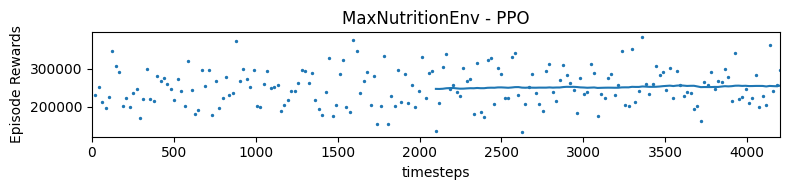

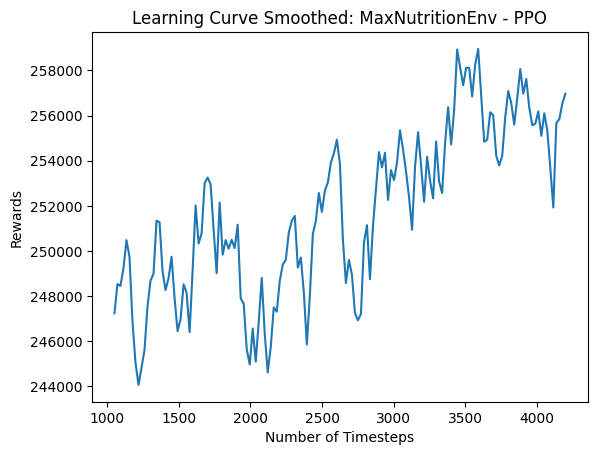

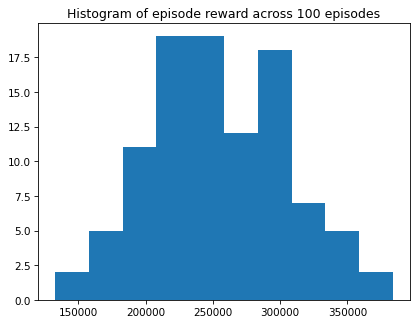

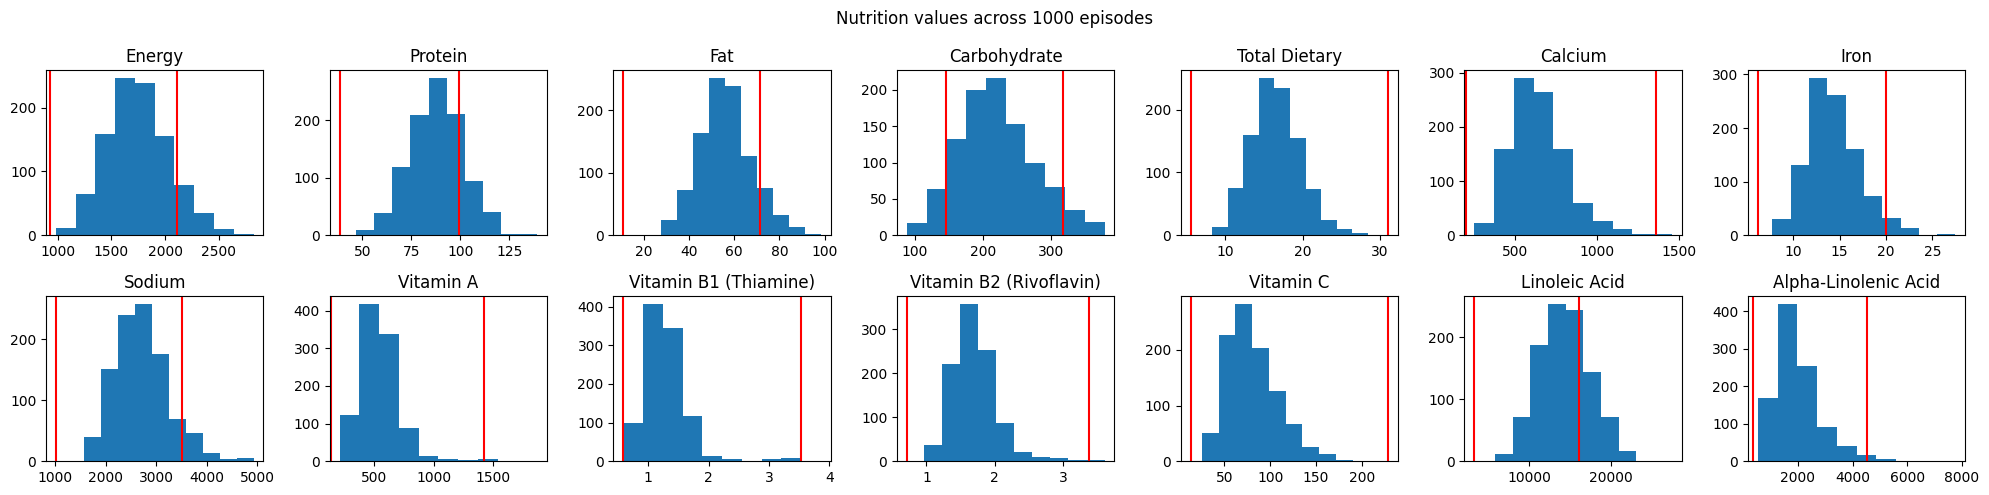

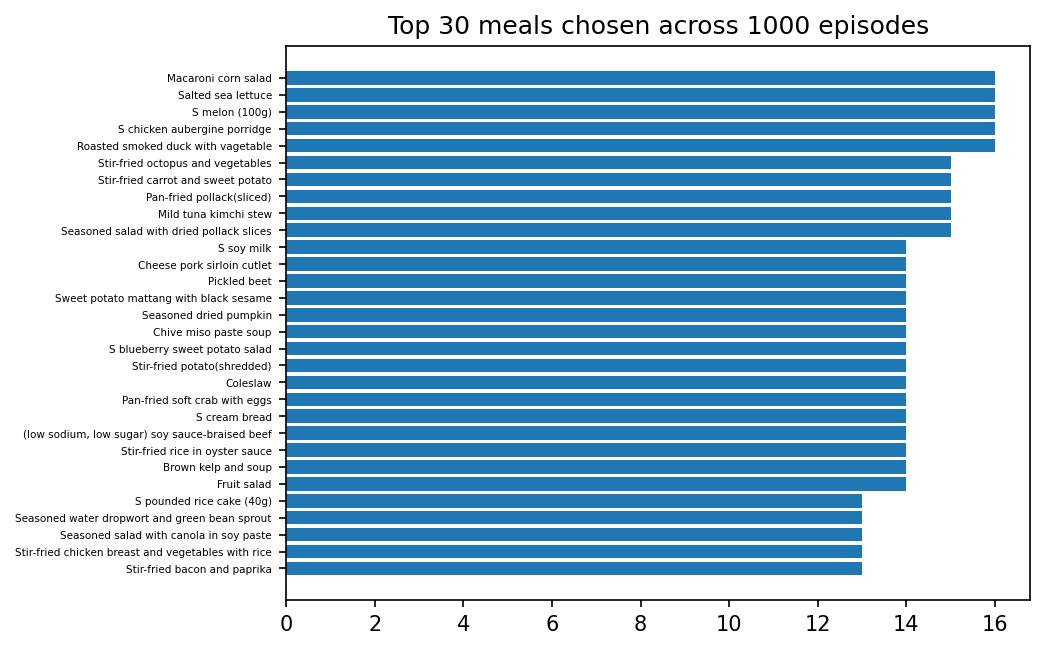

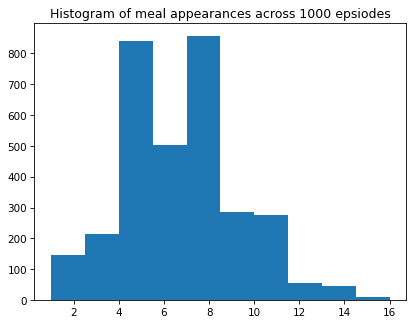

In [16]:
log_dir = f"./tmp/gym/{time.strftime('%Y%m%d-%H%M%S')}"
print(log_dir)
os.makedirs(log_dir, exist_ok=False)

heuristic_env.set_reward_weights(
    coef_nutrition_lower=1,
    coef_nutrition_upper=-1,
    coef_sequence_entropy=0,
    coef_repetitions=0,
    coef_overall_entropy=1
)
model, _ = run_with_learning_algorithm(PPO, max_env, 50000, log_dir, num_meals=21, seed=0)

./tmp/gym/20230425-132926
Using cpu device
Wrapping the env in a DummyVecEnv.
Initial Results
Step: 21
Chosen Meal: Braised chicken and walnut
Chosen Meal Category: Braised
Meal History: ['Seasoned salad with cabbage in soy paste'
 'Ketchup-braised meatballs and paprika'
 'Perilla seed korean-leek onion soup' 'Chicken seaweed soup'
 'Green bean sprout miso paste soup' 'Steamed millet rice (30)'
 'Lettuce salad (oriental dressing)' 'Grilled tofu in teriyaki sauce'
 'S seafood porridge' 'Braised white bait'
 'Seasoned salad with chwinamul and perilla seed'
 'Braised quail eggs and paprika in ketchup' 'Beef perilla leaf soup'
 'Stir-fried beef chop' 'Marinated chicken'
 'Curled mallow soup(soy paste+red pepper paste)'
 'Stir-fried baby anchovy' 'Cuttlefish daikon soup(clear)'
 'Stir-fried pork and mushroom'
 'Braised chicken and lotus root in soy sauce'
 'Braised chicken and walnut']
Category History: ['Salad' 'Braised' 'Soup' 'Soup' 'Soup' 'Rice' 'Salad' 'Grilled'
 'Soup (snack)' 'Braise

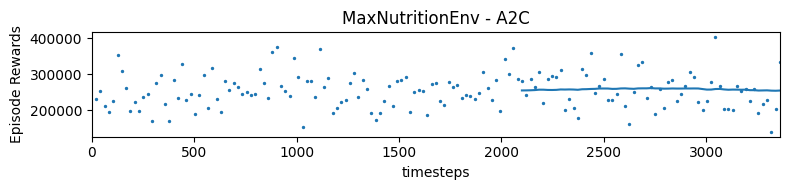

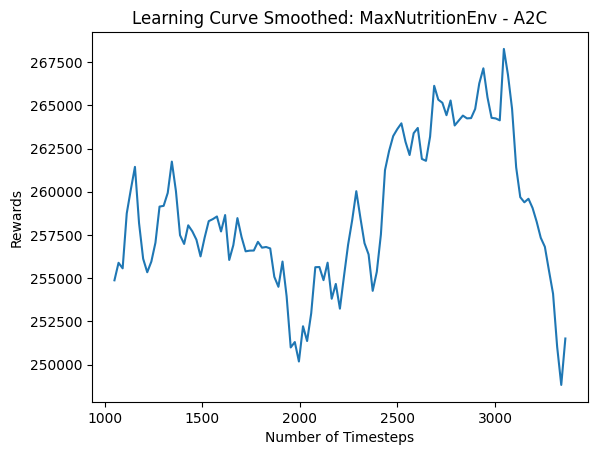

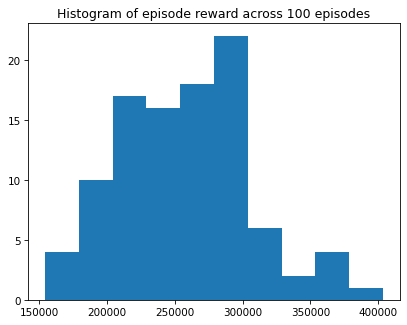

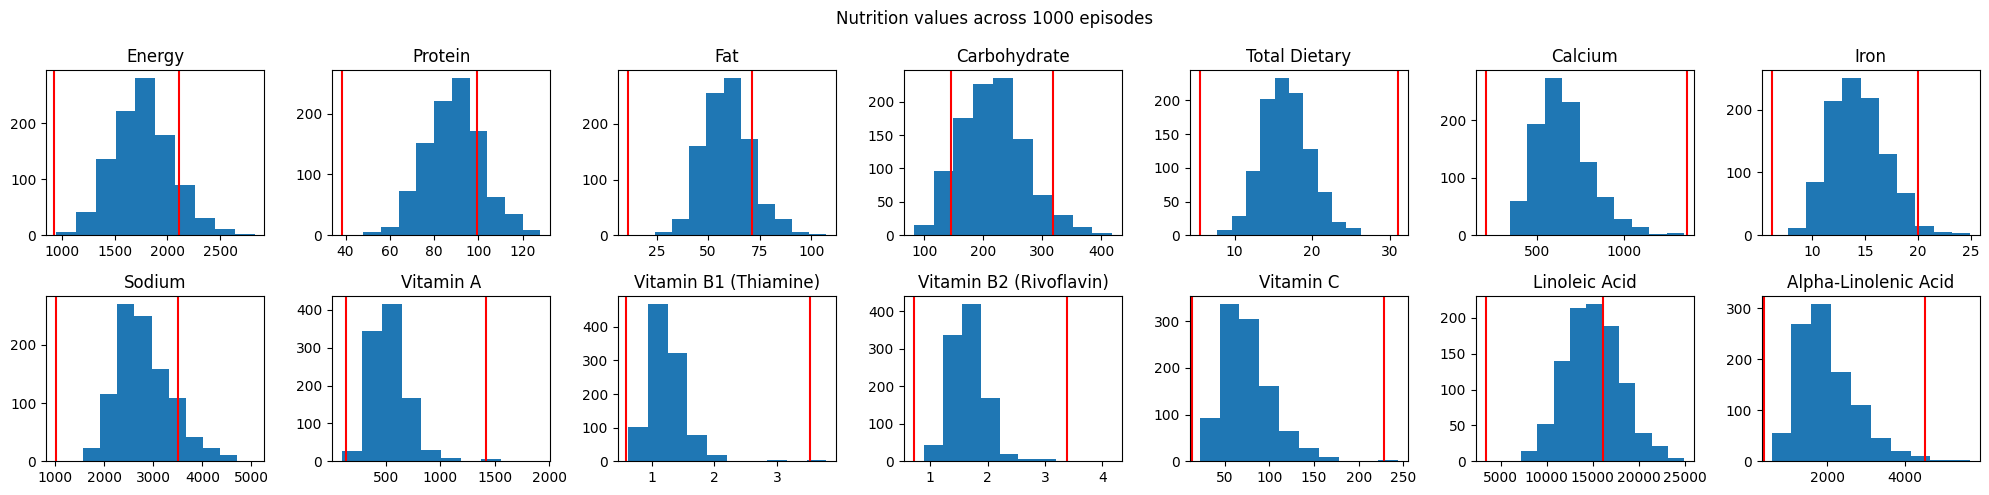

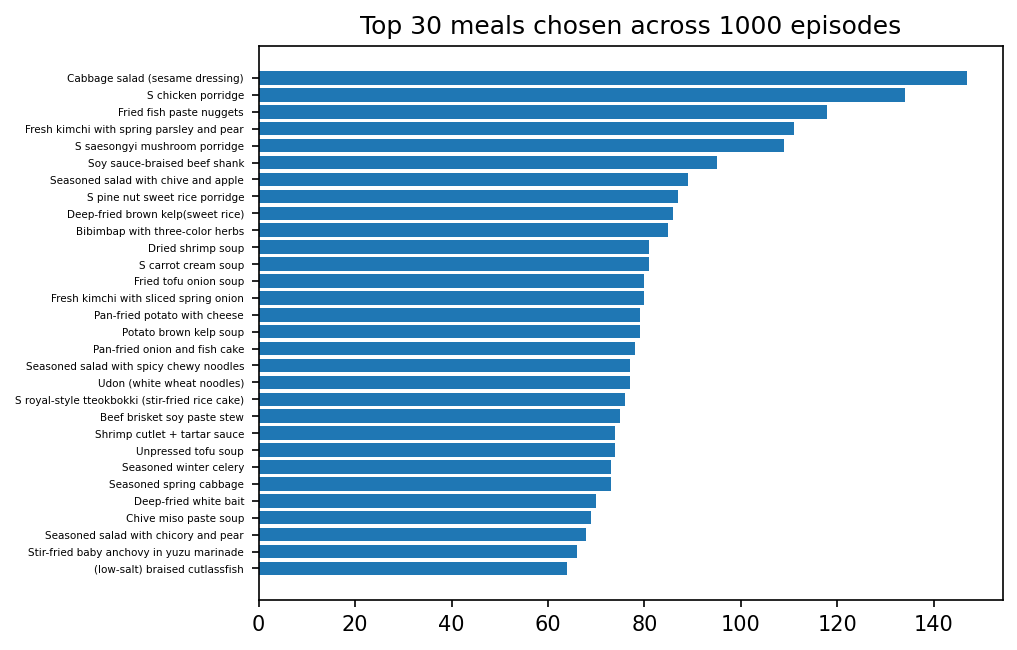

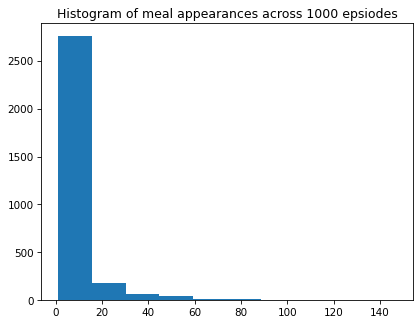

(<stable_baselines3.a2c.a2c.A2C at 0x15e217f70>,
 <Monitor<MaxNutritionEnv instance>>)

In [12]:
log_dir = f"./tmp/gym/{time.strftime('%Y%m%d-%H%M%S')}"
print(log_dir)
os.makedirs(log_dir, exist_ok=False)

heuristic_env.set_reward_weights(
    coef_nutrition_lower=1,
    coef_nutrition_upper=-1,
    coef_sequence_entropy=0,
    coef_repetitions=0,
    coef_overall_entropy=1
)
run_with_learning_algorithm(A2C, max_env, 1000, log_dir, num_meals=21, seed=0)

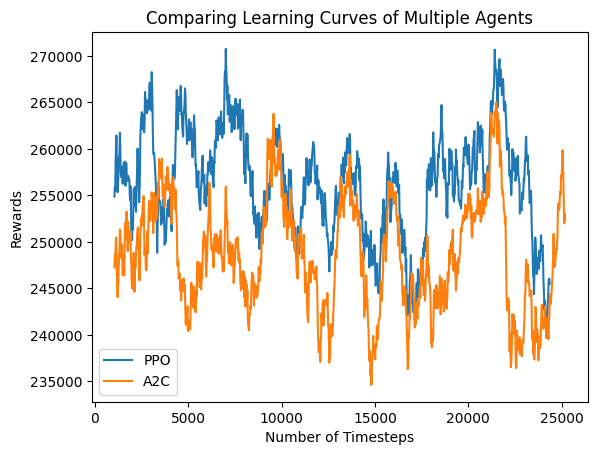

In [9]:
from stable_baselines3.common.results_plotter import load_results, ts2xy
import matplotlib.pyplot as plt
import numpy as np
import time

def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, "valid")

def plot_learning_multiple_agents(log_folders, title="Comparing Learning Curves of Multiple Agents"):
    """
    plot the learning curve

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    fig = plt.figure(title)
    all_models = ""
    for model, log in log_folders:
        x, y = ts2xy(load_results(log), "timesteps")
        y = moving_average(y, window=50)
        # Truncate x
        x = x[len(x) - len(y) :]
        plt.plot(x, y, label=model)
        all_models += model + ", "

    plt.xlabel("Number of Timesteps")
    plt.ylabel("Rewards")
    plt.title(title)
    plt.legend(loc="best")
    plt.savefig(f"Comparing {all_models}{time.strftime('%Y%m%d-%H%M%S')}.png", bbox_inches='tight')
    plt.show()

plot_learning_multiple_agents([('PPO','./tmp/gym/20230425-132926'), ('A2C','./tmp/gym/20230425-132914')])

In [ ]:
def min_reward_meal_sample(model, env, min_reward, give_up_after=1000):
    episode_reward = 0
    attempts = 0
    while episode_reward < min_reward and attempts < give_up_after:
        obs = env.reset()
        done, state = False, None
        episode_reward = 0
        while not done:
            action, state = model.predict(obs, state=state, deterministic=False)
            obs, reward, done, _ = env.step(action)
            episode_reward += reward
        attempts += 1
    env.render()
    print(f'Epsiode reward: {episode_reward}')

In [48]:
vec_env = model.get_env()
obs = vec_env.reset()
all_rewards = []
for i in range(100000):
    action, _states = model.predict(obs, deterministic=False)
    obs, rewards, dones, info = vec_env.step(action)
    all_rewards.append(rewards[0])

def plot_rewards(all_rewards, title="Learning Curve"):
    """
    plot the learning curve

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    y = all_rewards
    y = moving_average(y, window=50)
    # Truncate x
    x = np.arange(len(y))

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel("Number of Timesteps")
    plt.ylabel("Learning Curve Smoothed - MaxNutritionEnv: Random")
    plt.title(title)
    plt.show()


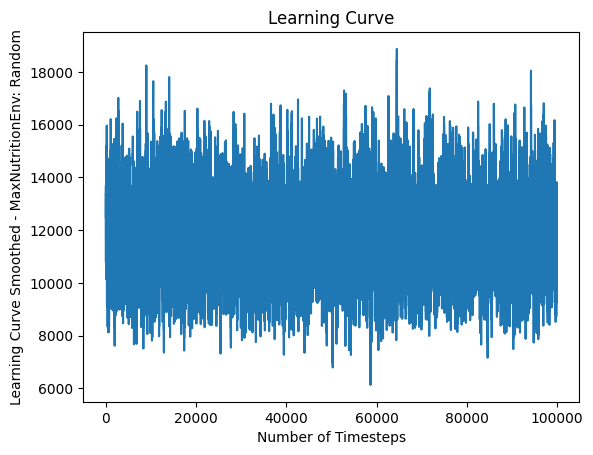

In [49]:
plot_rewards(all_rewards=all_rewards)